# Plot data

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import models
from omegaconf import OmegaConf

In [2]:
# !pip install omegaconf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import torch

In [4]:
def plot_time_series(path):
    wav = np.load(path)
    plt.figure(figsize=(10,3))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylabel(u"Voltage (\u03bcV)", fontsize=25)
    plt.xticks(np.arange(0,len(wav)+1, 2048), [x/2048 for x in np.arange(0,len(wav)+1, 2048)])
    plt.xlabel("Time (s)", fontsize=25)
    plt.plot(wav)

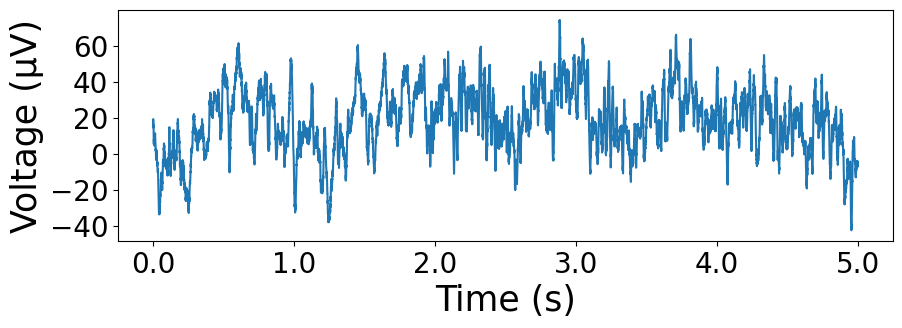

In [5]:
plot_time_series("example_wav_1.npy")

In [6]:
def get_stft(x, fs, clip_fs=-1, normalizing=None, **kwargs):
    f, t, Zxx = signal.stft(x, fs, **kwargs)
   
    Zxx = Zxx[:clip_fs]
    f = f[:clip_fs]

    Zxx = np.abs(Zxx)
    clip = 5 #To handle boundary effects
    if normalizing=="zscore":
        Zxx = Zxx[:,clip:-clip]
        Zxx = stats.zscore(Zxx, axis=-1)
        t = t[clip:-clip]
    elif normalizing=="baselined":
        Zxx = baseline(Zxx[:,clip:-clip])
        t = t[clip:-clip]
    elif normalizing=="db":
        Zxx = np.log2(Zxx[:,clip:-clip])
        t = t[clip:-clip]

    if np.isnan(Zxx).any():
        import pdb; pdb.set_trace()

    return f, t, Zxx

def plot_stft(path):
    wav = np.load(path)

    # f: frequency; t: time; linear: Normalized power spectrogram
    f,t,linear = get_stft(wav, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
    plt.figure(figsize=(15,3))
    f[-1]=200
    g1 = plt.pcolormesh(t,f,linear, shading="gouraud", vmin=-3, vmax=5)

    cbar = plt.colorbar(g1)
    tick_font_size = 15
    cbar.ax.tick_params(labelsize=tick_font_size)
    cbar.ax.set_ylabel("Power (Arbitrary units)", fontsize=15)
    plt.xticks(fontsize=20)
    plt.ylabel("")
    plt.yticks(fontsize=20)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Frequency (Hz)", fontsize=20)

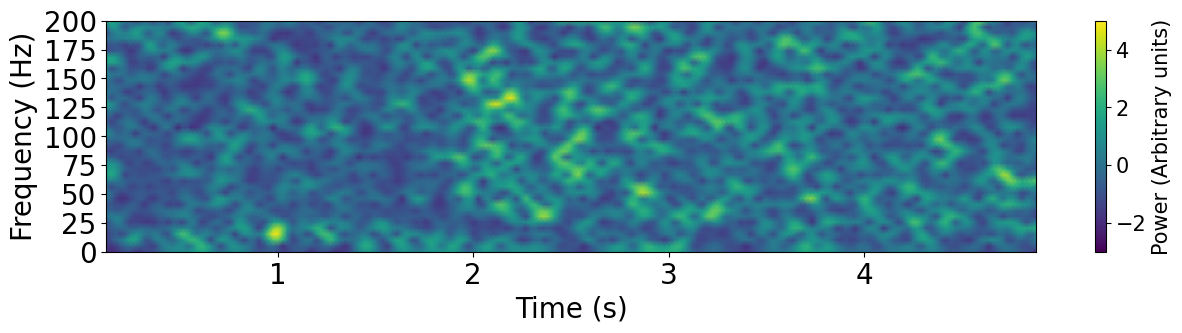

In [7]:
plot_stft("example_wav_1.npy")

# Load model

In [8]:
def build_model(cfg):
    ckpt_path = cfg.upstream_ckpt
    init_state = torch.load(ckpt_path)
    upstream_cfg = init_state["model_cfg"]
    upstream = models.build_model(upstream_cfg)
    return upstream

def load_model_weights(model, states, multi_gpu):
    if multi_gpu:
        model.module.load_weights(states)
    else:
        model.load_weights(states)

In [ ]:
# ckpt_path = "../pretrained_weights/stft_large_pretrained.pth"
ckpt_path = f"F:\TUD\Thesis\Dataset\BrainBERT\pretrained_weights\stft_large_pretrained.pth"
cfg = OmegaConf.create({"upstream_ckpt": ckpt_path})
model = build_model(cfg)
model.to('cuda')
init_state = torch.load(ckpt_path)
load_model_weights(model, init_state['model'], False)

dict_keys(['upstream_ckpt'])


# Get output

In [10]:
wav = np.load("example_wav_1.npy")

f,t,linear = get_stft(wav, 2048, clip_fs=40, nperseg=400, noverlap=350, normalizing="zscore", return_onesided=True) #TODO hardcode sampling rate
inputs = torch.FloatTensor(linear).unsqueeze(0).transpose(1,2).to('cuda')
mask = torch.zeros((inputs.shape[:2])).bool().to('cuda')
with torch.no_grad():
    out = model.forward(inputs, mask, intermediate_rep=True)

d:\Anaconda3\envs\brainbert\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


In [11]:
inputs.shape, out.shape

(torch.Size([1, 196, 40]), torch.Size([1, 196, 768]))

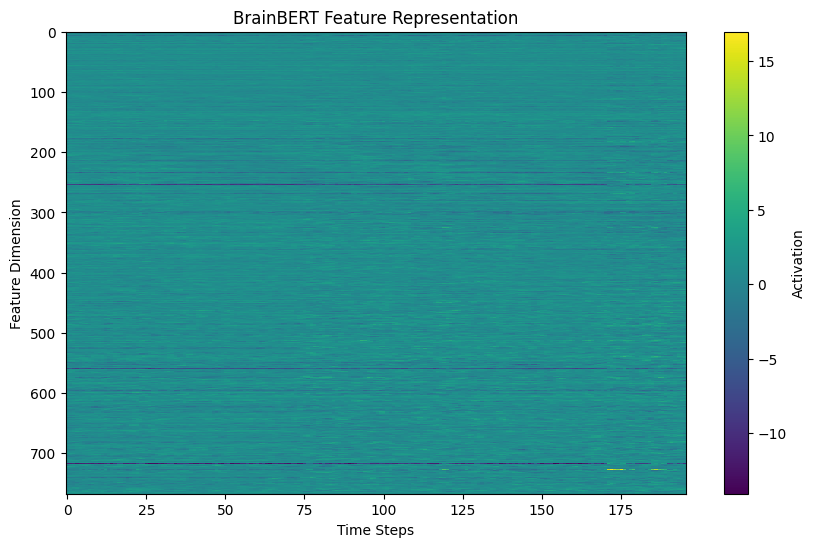

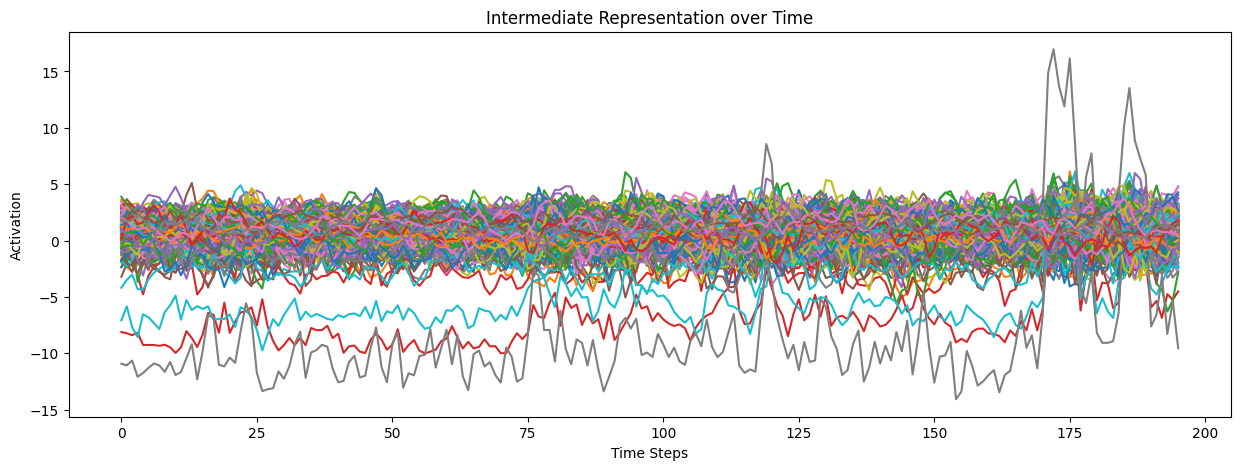

In [14]:
import matplotlib.pyplot as plt

output_features = out.squeeze(0).cpu().numpy()  # Shape: (T, D)

plt.figure(figsize=(10, 6))
plt.imshow(output_features.T, aspect="auto", cmap="viridis", interpolation="nearest")
plt.colorbar(label="Activation")
plt.xlabel("Time Steps")
plt.ylabel("Feature Dimension")
plt.title("BrainBERT Feature Representation")
plt.show()

out_np = out.cpu().numpy()[0]
plt.figure(figsize=(15, 5))
for i in range(out_np.shape[-1]):
    plt.plot(out_np[:, i], label=f'Unit {i}')
plt.xlabel("Time Steps")
plt.ylabel("Activation")
plt.title("Intermediate Representation over Time")

# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
